In [1]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt
from utils.PositionSensitiveScoreMap import PositionSensitiveScoreMap

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
# dataset_root_dir = "../Datasets/VOCtrainval_11-May-2012/VOCdevkit/VOC2012"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
val_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 1
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
val_loader = td.DataLoader(val_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


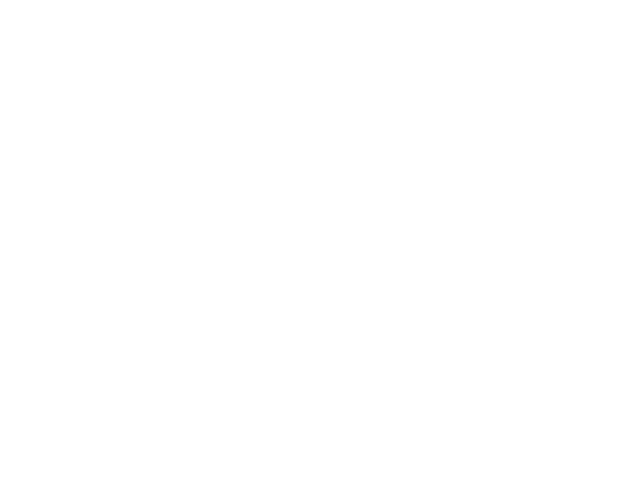

Bounding box corners tensor([[  0,   0, 250, 197]])


In [3]:
#Training set image demo
fig, ax = plt.subplots()
x, bbox, bbox_labels, scale = train_set.__getitem__(15)
h = myimshow(x, ax)

print("Bounding box corners", bbox)

In [4]:
tensor_im = x.to(device).unsqueeze(0)

In [5]:
#before running, $cd Multi-Object-Detection/model/utils/nms
#then            $python3 build.py build_ext --inplace

from model.region_proposal_network import RegionProposalNetwork
from model.resnet101extractor import Resnet101Extractor
from model.rfcn_resnet101 import Resnet101RoIHead
from model.rfcn_resnet101 import RFCNResnet101

n_fg_class = 20
feat_stride = 520//16
extractor = Resnet101Extractor().to(device)
rpn = RegionProposalNetwork(in_channels=1024, mid_channels = 1024).to(device)
head = Resnet101RoIHead( #Main class to change
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / feat_stride)
        ).to(device)

rfcn = RFCNResnet101().to(device)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:83: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:87: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)


In [6]:
out = rfcn(tensor_im)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


In [7]:
from trainer import FasterRCNNTrainer
trainer = FasterRCNNTrainer(rfcn).to(device)

In [ ]:
train_loader = td.DataLoader(train_set, batch_size=1, pin_memory = True, shuffle = True)
val_loader  = td.DataLoader(val_set, batch_size=1, pin_memory = True, shuffle = False)

In [ ]:
import time
t = time.time()
img, bboxes, lbls, scale = next(iter(train_loader))
img = img.to(device)
bboxes = bboxes.to(device)
lbls = lbls.to(device)
scale = scale.item()
loss =trainer.train_step(img, bboxes, lbls, scale)
elapsed = time.time() - t
print("Elapsed time: ", elapsed)
print("Loss tuple: ", loss)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


Elapsed time:  3.2868213653564453
Loss tuple:  LossTuple(rpn_loc_loss=tensor(12.1658, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(2.7280, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(7.0982, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0153, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(25.0072, device='cuda:0', grad_fn=<AddBackward0>))


In [ ]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import matplotlib
from tqdm import tqdm


from utils.config import opt
from model.rfcn_resnet101 import RFCNResnet101
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (20480, rlimit[1]))

matplotlib.use('agg')


def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result


def train(train_set,val_set, load_path = False, epochs = 1, lr=1e-3, plot_every = 40, lr_decay = 1e-3,test_num=500):

    train_dataloader = td.DataLoader(train_set, batch_size = 1, pin_memory = False, shuffle = True)
    test_dataloader = td.DataLoader(val_set, batch_size = 1, pin_memory = True)
    faster_rcnn = RFCNResnet101().cuda()
    print('model construct completed')
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()
    if load_path:
        trainer.load(load_path)
        print('load pretrained model from %s' % load_path)
#     trainer.vis.text(dataset.db.label_names, win='labels')
    best_map = 0
    lr_ = lr
    for epoch in range(epochs):
        trainer.reset_meters()
        for ii, (img, bbox_, label_, scale) in tqdm(enumerate(train_dataloader)):
            scale = at.scalar(scale)
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            trainer.train_step(img, bbox, label, scale)
            loss_info = 'Iter {}; Losses: RPN loc {}, RPN cls: {}, ROI loc {}, ROI cls {}, Total:{}'.format(
                                                str(ii),
                                                str(trainer.meters['rpn_loc_loss'].value()),
                                                str(trainer.meters['rpn_cls_loss'].value()),
                                                str(trainer.meters['roi_loc_loss'].value()),
                                                str(trainer.meters['roi_cls_loss'].value()),                                
                                                str(trainer.meters['total_loss'].value()))
            print(loss_info)
#             if (ii + 1) % plot_every == 0:


#                 # plot loss
#                 trainer.vis.plot_many(trainer.get_meter_data())

#                 # plot groud truth bboxes
#                 ori_img_ = inverse_normalize(at.tonumpy(img[0]))
#                 gt_img = visdom_bbox(ori_img_,
#                                      at.tonumpy(bbox_[0]),
#                                      at.tonumpy(label_[0]))
#                 trainer.vis.img('gt_img', gt_img)

#                 # plot predicti bboxes
#                 _bboxes, _labels, _scores = trainer.faster_rcnn.predict([ori_img_], visualize=True)
#                 pred_img = visdom_bbox(ori_img_,
#                                        at.tonumpy(_bboxes[0]),
#                                        at.tonumpy(_labels[0]).reshape(-1),
#                                        at.tonumpy(_scores[0]))
#                 trainer.vis.img('pred_img', pred_img)

#                 # rpn confusion matrix(meter)
#                 trainer.vis.text(str(trainer.rpn_cm.value().tolist()), win='rpn_cm')
#                 # roi confusion matrix
#                 trainer.vis.img('roi_cm', at.totensor(trainer.roi_cm.conf, False).float())
#         eval_result = eval(test_dataloader, faster_rcnn, test_num=test_num)
#         trainer.vis.plot('test_map', eval_result['map'])
#         lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
#         log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_),
#                                                   str(eval_result['map']),
#                                                   str(trainer.get_meter_data()))
#         print(log_info)

        if eval_result['map'] > best_map:
            best_map = eval_result['map']
            best_path = trainer.save(best_map=best_map)
        if epoch == 9:
            trainer.load(best_path)
            trainer.faster_rcnn.scale_lr(opt.lr_decay)
            lr_ = lr_ * lr_decay

        if epoch == 13: 
            break



In [ ]:
train(train_set,val_set, load_path = False, epochs = 1, lr=1e-3, plot_every =40)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:83: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:87: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)
0it [00:00, ?it/s]

model construct completed


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])
1it [00:01,  1.97s/it]

Iter 0; Losses: RPN loc (0.5363680124282837, inf), RPN cls: (4.788933277130127, inf), ROI loc (1.8749611377716064, inf), ROI cls (3.059299945831299, inf), Total:(10.259561538696289, inf)


2it [00:02,  1.60s/it]

Iter 1; Losses: RPN loc (1.4885223507881165, 1.3465495787808563), RPN cls: (15.062766313552856, 14.52939401766578), ROI loc (35.43205988407135, 47.456904160910284), ROI cls (3.047126054763794, 0.01721648185451808), Total:(55.03047275543213, 63.31562984250955)


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/utils/bbox_tools.py:68: RuntimeWarning: overflow encountered in multiply
  h = xp.exp(dh) * src_height[:, xp.newaxis]
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/utils/bbox_tools.py:69: RuntimeWarning: overflow encountered in multiply
  w = xp.exp(dw) * src_width[:, xp.newaxis]
3it [00:05,  1.94s/it]

Iter 2; Losses: RPN loc (2.697431604067485, 2.3002136057442337), RPN cls: (30.9129900932312, 29.31280312180897), ROI loc (77.79761226971945, 80.6882826877124), ROI cls (3.02962056795756, 0.03267307498068005), Total:(114.43765830993652, 112.2144178690902)


4it [00:08,  2.29s/it]

Iter 3; Losses: RPN loc (13.379962474107742, 21.447451711384105), RPN cls: (26.96107566356659, 25.205107852897356), ROI loc (79.22648221254349, 65.94365766305468), ROI cls (3.002214729785919, 0.06095905524220988), Total:(122.56973695755005, 93.05503674881376)


5it [00:12,  2.66s/it]

Iter 4; Losses: RPN loc (34.71082727909088, 51.18616859393225), RPN cls: (24.283642864227296, 22.634405854407362), ROI loc (97.85869126319885, 70.69102177803934), ROI cls (2.928189182281494, 0.17374093711231828), Total:(159.78135108947754, 115.83587971677704)


6it [00:15,  2.79s/it]

Iter 5; Losses: RPN loc (32.7717571457227, 46.02802453021298), RPN cls: (25.402880907058716, 20.429616381242965), ROI loc (98.09613533814748, 63.23064704833373), ROI cls (2.814548810323079, 0.3188001496486698), Total:(159.08532238006592, 103.62078729479748)


7it [00:21,  3.87s/it]

Iter 6; Losses: RPN loc (30.03754808221544, 42.63582800355819), RPN cls: (22.753711359841482, 19.923212164038237), ROI loc (124.96340932164873, 91.56809024394974), ROI cls (2.7431722368512834, 0.3469249479796766), Total:(180.49784224373954, 110.25967084439158)


8it [00:26,  4.33s/it]

Iter 7; Losses: RPN loc (27.082921698689457, 40.34804426664629), RPN cls: (22.34595626592636, 18.481330710167477), ROI loc (122.16890040040016, 85.14324953676369), ROI cls (2.6743144392967224, 0.3756251378115922), Total:(174.27209305763245, 103.5882835709763)


9it [00:33,  5.03s/it]

Iter 8; Losses: RPN loc (27.517171608077152, 37.76461635551951), RPN cls: (22.687856409284805, 17.31810318968315), ROI loc (159.4861220518748, 137.39132654588224), ROI cls (2.6543477641211615, 0.35643439325432336), Total:(212.34549819098578, 149.78475736058553)


10it [01:06, 13.27s/it]

Iter 9; Losses: RPN loc (24.826965838670727, 36.60704034471125), RPN cls: (20.512571096420288, 17.717541659236026), ROI loc (144.17030608654022, 138.29223990515226), ROI cls (2.602148199081421, 0.3744025354091282), Total:(192.1119915008545, 155.03738605350026)


11it [01:36, 18.37s/it]

Iter 10; Losses: RPN loc (22.604889574376017, 35.50185508796895), RPN cls: (18.79261524027044, 17.749954473751004), ROI loc (137.19980246370488, 133.216877250975), ROI cls (2.562913786281239, 0.3782753802380364), Total:(181.16022109985352, 151.50011878196835)


12it [01:47, 16.27s/it]

Iter 11; Losses: RPN loc (21.470712152620155, 34.076940295377845), RPN cls: (17.90781056880951, 17.199230708691314), ROI loc (151.04168039560318, 135.76659283255918), ROI cls (2.5368745525677996, 0.3717800102622859), Total:(192.9570779800415, 150.1189679029516)


13it [02:09, 17.86s/it]

Iter 12; Losses: RPN loc (19.865579969607865, 33.135507834664224), RPN cls: (16.604592304963333, 17.1242903751303), ROI loc (142.1605999836555, 133.87261512074454), ROI cls (2.5059456275059624, 0.37301178350376046), Total:(181.1367181631235, 149.91364490214065)


14it [02:47, 23.82s/it]

Iter 13; Losses: RPN loc (18.51496616218771, 32.234166354100395), RPN cls: (15.497559802872795, 16.965894895951166), ROI loc (157.56341557843345, 140.94227664383354), ROI cls (2.486342549324035, 0.3658070708718024), Total:(194.06228365216936, 151.93520769840703)


15it [03:27, 28.83s/it]

Iter 14; Losses: RPN loc (17.517719854911167, 31.300826425099316), RPN cls: (14.674530267715454, 16.656594499244516), ROI loc (170.19698897997537, 144.36039638929984), ROI cls (2.4684302012125645, 0.359262293299902), Total:(204.8576675415039, 152.26139675745995)


16it [03:50, 27.04s/it]

Iter 15; Losses: RPN loc (16.563601372763515, 30.479355184816402), RPN cls: (13.86036017537117, 16.41803778327559), ROI loc (168.98510937392712, 139.5496120053257), ROI cls (2.4489347934722896, 0.3557329107565361), Total:(201.85800409317017, 147.5870311800784)


17it [04:28, 30.40s/it]

Iter 16; Losses: RPN loc (15.662523204789442, 29.744447564270697), RPN cls: (13.089699780239778, 16.211155523924184), ROI loc (186.99099915167864, 154.17058233127605), ROI cls (2.4374239584978885, 0.34769134771927324), Total:(218.18064476461973, 157.95520634370524)


18it [05:09, 33.53s/it]

Iter 17; Losses: RPN loc (14.856358923845821, 29.058343171572037), RPN cls: (12.404588434431288, 15.993481295087458), ROI loc (197.77450226412878, 156.4082103966037), ROI cls (2.4277778598997326, 0.33978373928652894), Total:(227.46322674221463, 158.21884542277576)


19it [05:48, 35.13s/it]

Iter 18; Losses: RPN loc (14.12322401843573, 28.419872464259438), RPN cls: (11.817190596931859, 15.752348914766774), ROI loc (200.1274109263169, 152.34707341899528), ROI cls (2.4164148757332247, 0.3339044253771222), Total:(228.48423967863386, 153.82547391514882)


20it [06:29, 36.86s/it]

Iter 19; Losses: RPN loc (13.483170114457607, 27.8095770477546), RPN cls: (11.262963345646858, 15.531260015125698), ROI loc (192.22452968358994, 152.43746883021882), ROI cls (2.4025338411331174, 0.33087432511231224), Total:(219.37319622039797, 155.168024133289)


21it [07:09, 37.97s/it]

Iter 20; Losses: RPN loc (12.859581778446833, 27.255642672027236), RPN cls: (10.762894071283794, 15.310469967867485), ROI loc (192.38812222934905, 148.57955721140553), ROI cls (2.396671238399687, 0.3236135046542592), Total:(218.40726852416995, 151.30384420218365)


22it [07:50, 38.77s/it]

Iter 21; Losses: RPN loc (12.296589386734095, 26.729542127631216), RPN cls: (10.304103027690541, 15.095656633545836), ROI loc (185.46522889354011, 148.5901549823026), ROI cls (2.389210917732932, 0.3177470735325518), Total:(210.45513153076175, 152.29550230096774)


23it [08:31, 39.35s/it]

Iter 22; Losses: RPN loc (11.843598444824632, 26.205194203106664), RPN cls: (9.89366055312364, 14.87936051254482), ROI loc (179.60217586807582, 147.8718218048287), ROI cls (2.3810406249502427, 0.31290461963024624), Total:(203.7204747407333, 152.25908766659433)


24it [09:11, 39.71s/it]

Iter 23; Losses: RPN loc (11.37960873916745, 25.72978868229298), RPN cls: (9.50401776532332, 14.67696152792581), ROI loc (172.3415599167347, 148.93143992096003), ROI cls (2.371272544066111, 0.3097456126500258), Total:(195.59645823637646, 154.1391323325626)


25it [09:52, 40.10s/it]

Iter 24; Losses: RPN loc (10.930918046832083, 25.287761031811772), RPN cls: (9.151806874275207, 14.475460700763943), ROI loc (168.47466143608094, 147.07211094748888), ROI cls (2.3635359096527098, 0.305681426762037), Total:(190.92092144012452, 152.69392659735934)


26it [10:33, 40.33s/it]

Iter 25; Losses: RPN loc (10.511626978046618, 24.86891541043521), RPN cls: (8.824590721955666, 14.28079951081857), ROI loc (165.01244782484494, 145.17802032726573), ROI cls (2.355793439424955, 0.3020961457160669), Total:(186.70445820001456, 151.1458250484152)


27it [11:14, 40.48s/it]

Iter 26; Losses: RPN loc (10.125933982431887, 24.468191848935902), RPN cls: (8.52334236215662, 14.090692194946103), ROI loc (169.23688891198898, 144.04116174628732), ROI cls (2.3518073558807373, 0.29695285902438473), Total:(190.23797137648972, 149.34362582361172)


28it [11:55, 40.55s/it]

Iter 27; Losses: RPN loc (9.782775127195885, 24.0793655087515), RPN cls: (8.244172679526466, 13.905976823062192), ROI loc (168.60090271915706, 141.38862242801156), ROI cls (2.346710903303964, 0.29264706509752964), Total:(188.97456015859333, 146.70431538305323)


29it [12:35, 40.63s/it]

Iter 28; Losses: RPN loc (9.447819711833164, 23.714168621159054), RPN cls: (7.979005589567382, 13.729857713601405), ROI loc (163.18805710200604, 141.86773943896807), ROI cls (2.3392719646980025, 0.2901524554272504), Total:(182.95415312668374, 147.6638799506369)


30it [13:17, 41.02s/it]

Iter 29; Losses: RPN loc (9.138130557040373, 23.36337365603675), RPN cls: (7.72930961449941, 13.560203727706682), ROI loc (160.11435129642484, 140.41321094621986), ROI cls (2.3344122886657717, 0.28634575431564147), Total:(179.31620254516602, 146.45742889003765)


31it [14:00, 41.46s/it]

Iter 30; Losses: RPN loc (8.849430981662966, 23.026855880935813), RPN cls: (7.496995622111905, 13.394882772481047), ROI loc (159.2506826077738, 138.13688059193254), ROI cls (2.333394365925943, 0.2815899189991349), Total:(177.93050236855785, 144.20232652610275)


32it [14:41, 41.25s/it]

Iter 31; Losses: RPN loc (8.589053950738162, 22.700246255228866), RPN cls: (7.280293619260192, 13.233962436182424), ROI loc (154.7789555415511, 138.22495755239987), ROI cls (2.3292662352323537, 0.27799347902408517), Total:(172.97756814956668, 144.59784433596596)


33it [15:22, 41.19s/it]

Iter 32; Losses: RPN loc (8.339625751881888, 22.38863761469701), RPN cls: (7.083053298068769, 13.074728688169323), ROI loc (154.11904314070037, 136.1008561121979), ROI cls (2.3289394306414057, 0.27362179577198176), Total:(171.87066049286815, 142.462549074386)


34it [16:04, 41.56s/it]

Iter 33; Losses: RPN loc (8.103409976205405, 22.089789394538002), RPN cls: (6.894708093474893, 12.921856868244982), ROI loc (152.94727849259095, 134.19690637329202), ROI cls (2.3254149380852196, 0.27022672441999585), Total:(170.2708102955538, 140.59724065294333)


35it [16:48, 42.19s/it]

Iter 34; Losses: RPN loc (7.887055104545185, 21.800123767606607), RPN cls: (6.717272967951638, 12.77361681099226), ROI loc (151.44409950120107, 132.50744490413214), ROI cls (2.3218686308179586, 0.26704855896961055), Total:(168.37029506138396, 138.96979197982472)


36it [17:30, 42.29s/it]

Iter 35; Losses: RPN loc (7.669072823909422, 21.526205942463005), RPN cls: (6.549485650327471, 12.630000559373503), ROI loc (149.10272414816748, 131.35415040872348), ROI cls (2.3174342777993946, 0.2645472526010558), Total:(165.63871574401858, 137.94719766569372)


37it [18:13, 42.28s/it]

Iter 36; Losses: RPN loc (7.4698617479487055, 21.259686988142555), RPN cls: (6.390587494180009, 12.490800127545176), ROI loc (146.67327021908113, 130.35728053998864), ROI cls (2.3140842141331857, 0.2616418591342921), Total:(162.84780254879516, 137.07309857666658)


38it [18:55, 42.24s/it]

Iter 37; Losses: RPN loc (7.280036523644078, 21.003048513481055), RPN cls: (6.240136450842807, 12.355706306019503), ROI loc (143.65743583754488, 129.92062780663815), ROI cls (2.311732831754183, 0.2584886646565203), Total:(159.48934053119862, 136.78389804661037)


39it [19:37, 42.28s/it]

Iter 38; Losses: RPN loc (7.098553539182133, 20.755816556326145), RPN cls: (6.096315134794284, 12.225085547015688), ROI loc (140.28781447655115, 129.91533847556954), ROI cls (2.3083001100100007, 0.25596410544068304), Total:(155.7909821730394, 136.93395130257588)


40it [20:18, 41.82s/it]

Iter 39; Losses: RPN loc (6.926286836806686, 20.516936886562632), RPN cls: (5.95582251176238, 12.100005073454678), ROI loc (138.336240452528, 128.83156333413436), ROI cls (2.3054296493530275, 0.2533125855362685), Total:(153.52377834320072, 135.92543198350464)


41it [20:58, 41.24s/it]

Iter 40; Losses: RPN loc (6.77248946858979, 20.28277300016698), RPN cls: (5.825415880941763, 11.976940810241555), ROI loc (135.5886219013028, 128.42179773762575), ROI cls (2.301752468434776, 0.25123190955971403), Total:(150.48827864484093, 135.61568706670045)


42it [21:38, 41.08s/it]

Iter 41; Losses: RPN loc (6.621277078365288, 20.057848700995294), RPN cls: (5.703587989721979, 11.856296496662186), ROI loc (133.63716458706628, 127.4749158543118), ROI cls (2.299174592608497, 0.24871093758361662), Total:(148.26120322091242, 134.72695699407953)


43it [22:19, 40.90s/it]

Iter 42; Losses: RPN loc (6.484195621987416, 19.83800237709701), RPN cls: (5.585793256066566, 11.739738947756214), ROI loc (131.2444948761962, 126.92171690101492), ROI cls (2.2965349319369293, 0.24634114032524632), Total:(145.61101771509928, 134.24301713354794)


44it [23:00, 41.10s/it]

Iter 43; Losses: RPN loc (6.3499666317789405, 19.62617803973946), RPN cls: (5.47554764625701, 11.625450539248403), ROI loc (129.64792504635722, 125.8834739809866), ROI cls (2.294903039932251, 0.243700385185897), Total:(143.7683414979415, 133.23471886165981)


45it [23:41, 40.80s/it]

Iter 44; Losses: RPN loc (6.217371877117291, 19.42224958988168), RPN cls: (5.370984645022286, 11.51396926698949), ROI loc (127.6264907148149, 125.18137545757132), ROI cls (2.2926492320166694, 0.2413890884993334), Total:(141.50749562581385, 132.58228173907537)


46it [24:21, 40.65s/it]

Iter 45; Losses: RPN loc (6.082472735874195, 19.227015532486124), RPN cls: (5.268968911922496, 11.406322231949185), ROI loc (125.24398034033565, 124.83292245332407), ROI cls (2.2904934157495913, 0.2391393301760355), Total:(138.88591459523082, 132.3011014707621)


47it [25:01, 40.45s/it]

Iter 46; Losses: RPN loc (5.964612506270568, 19.034035932118535), RPN cls: (5.174040122869166, 11.300414784219251), ROI loc (122.6909439563751, 124.70299833224206), ROI cls (2.2881248149466007, 0.23708245992080215), Total:(136.11772062423387, 132.2241468477725)


{'rpn_loc_loss': <torchnet.meter.averagevaluemeter.AverageValueMeter at 0x7f4e0050df28>,
 'rpn_cls_loss': <torchnet.meter.averagevaluemeter.AverageValueMeter at 0x7f4e0050def0>,
 'roi_loc_loss': <torchnet.meter.averagevaluemeter.AverageValueMeter at 0x7f4e0050de80>,
 'roi_cls_loss': <torchnet.meter.averagevaluemeter.AverageValueMeter at 0x7f4e0050deb8>,
 'total_loss': <torchnet.meter.averagevaluemeter.AverageValueMeter at 0x7f4e0051d860>}

31.951778411865234